## Kuramoto model of $N$ coupled oscillators as defined in https://arxiv.org/abs/2108.12129

$$\dot{\theta_i} = \omega_i + K \sum^N_{j=1} A_{ij} \sin(\theta_j - \theta_i),$$

where $\theta_i$ is the phase angle of oscillator $i$, $\omega_i$ is the natural frequency of the oscillator $i$, $K$ is the coupling strenght and $A$ is the adjacency matrix of the oscillator network.



#### 1. Construct a regular frequency assortative network

Algorithm for adding edges to the network:

1. Draw natural frequencies $\omega$ uniformly from $[\frac{-\pi}{2}, \frac{\pi}{2}]$

While degree of all nodes is less than $d$:

Randomly select a node $i$ with degree < $d$

randomly pick a node $j$ not already connected to $i$ and that has degree < $d$

connect $i$ and $j$ with probability $p \propto \frac{\delta^{\gamma}}{\delta^{\gamma} + |{\omega_i - \omega_j}|^{\gamma}}$
        
In the paper, $N=50, d=3, \delta=0.8, \gamma=5, K=0.5$

In [1]:
!pwd

/scratch/work/tuomaaj3/reservoir_project/notebooks_analysis


In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import networkx as nx
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '..')
import reservoirpy.reservoirpy
import pandas as pd
import seaborn as sns
import pickle

In [3]:
def construct_data(a: np.ndarray, data: np.ndarray) -> dict:
    '''
    Given time series data for a network of kuramoto oscillators and its adjacency matrix, return training data for each reservoir for the parallel scheme.
    
    Parameters:
    a -- adjacency matrix of the system
    data -- time series data for all of the oscillators
    
    Returns:
    a dictionary with oscillator indices as keys and numpy arrays of the given oscillator and its neighbours as values.
    
    Note:
    assuming the first N/2 columns of data contain the sin(theta_i) and the latter N/2 contain the cos(theta_i)
    '''
    n_oscillators = data.shape[1] // 2
    oscillator_data = {}

    for oscillator_index in range(n_oscillators):
        # Calculate the column indices for the sin and cos of the oscillator
        sin_index = oscillator_index
        cos_index = n_oscillators + oscillator_index
        # Get the indices of the neighbors for the oscillator
        neighbors_indices = np.nonzero(a[oscillator_index])[0]

        # Calculate the column indices for the sin and cos of the neighbors
        neighbors_sin_indices = neighbors_indices
        neighbors_cos_indices = n_oscillators + neighbors_indices
        # Concatenate the sin and cos time series for oscillator i and its neighbors
        oscillator_data[oscillator_index] = np.concatenate(
        (data[:, sin_index].reshape(-1, 1),
        data[:, cos_index].reshape(-1, 1),),axis=1)

        for s, c in zip(neighbors_sin_indices, neighbors_cos_indices):
            oscillator_data[oscillator_index] = np.concatenate(
            (oscillator_data[oscillator_index],
             data[:, s].reshape(-1, 1),
             data[:, c].reshape(-1, 1)),axis=1)

    
    return oscillator_data

#### 3. Global order parameter:

$$R(t) = \frac{\sum^N_{i,j=1} A_{ij}e^{i \theta_j}}{N d}$$

In [4]:
def R_t(theta, a):
    e = np.e**(1j*theta)
    return np.sum(a * e[:,np.newaxis])

def calculate_R(a:np.ndarray, data:np.ndarray, N:int, d:int):
        R = np.apply_along_axis(R_t, axis=1, arr=data, a=a)
        return R/(N*d)

#### 4. Setting reservoir topology

Internal reservoir network $W$:

Directed graph with $N_r$ nodes, average in-degree $\kappa$

Adjacency matrix $\mathbf{W}$:

Elements chosen randomly and uniformly from $[ -\beta, \beta]$, where $\beta$ is chosen to yield a maximum eigenvalue of $\mathbf{W}$ $\rho$ (spectral radius).

Input matrix $\mathbf{W_{in}}$: dimensions $N_r \times N_{in}$, where $N_{in}$ is the number of inputs ($2N$, sine and cosine of each oscillator).

Nonzero elements of $\mathbf{W_{in}}$ are chosen so that each $N_r$ reservoir nodes receives exactly one input amongst $N_{in}$, and the strenght of the input is drawn uniformly from $[-\sigma, \sigma]$, where $\sigma$ is the input scaling parameter.

In [5]:
def recover_phases(data:np.ndarray):
    n_col = data.shape[1]
    sine_array = data[:, :int(n_col/2)]
    cosine_array = data[:, int(n_col/2):]
    return np.arctan2(sine_array, cosine_array)

#### 5. Single Reservoir

In [103]:
test = np.load("../notebooks/simulation_data/coupled_kuramoto/N30/lsoda_test_02.npy", allow_pickle=True)
test_data = np.concatenate((np.sin(test[0]["data"]), np.cos(test[0]["data"])), axis=1)
test_datadict = construct_data(a=test[0]["adjacency_matrix"], data=test_data)
N = test[0]["N"]
# prediction
outputs = np.load(f"../outputs/kuramoto/N{test[0]['N']}/pred_all_single_res_lsoda_{str(test[0]['dt'])[2:]}.npy")
out = construct_data(a=test[0]["adjacency_matrix"], data=outputs)

In [82]:
outputs.shape

(10000, 60)

In [8]:
test_data.shape

(15000, 60)

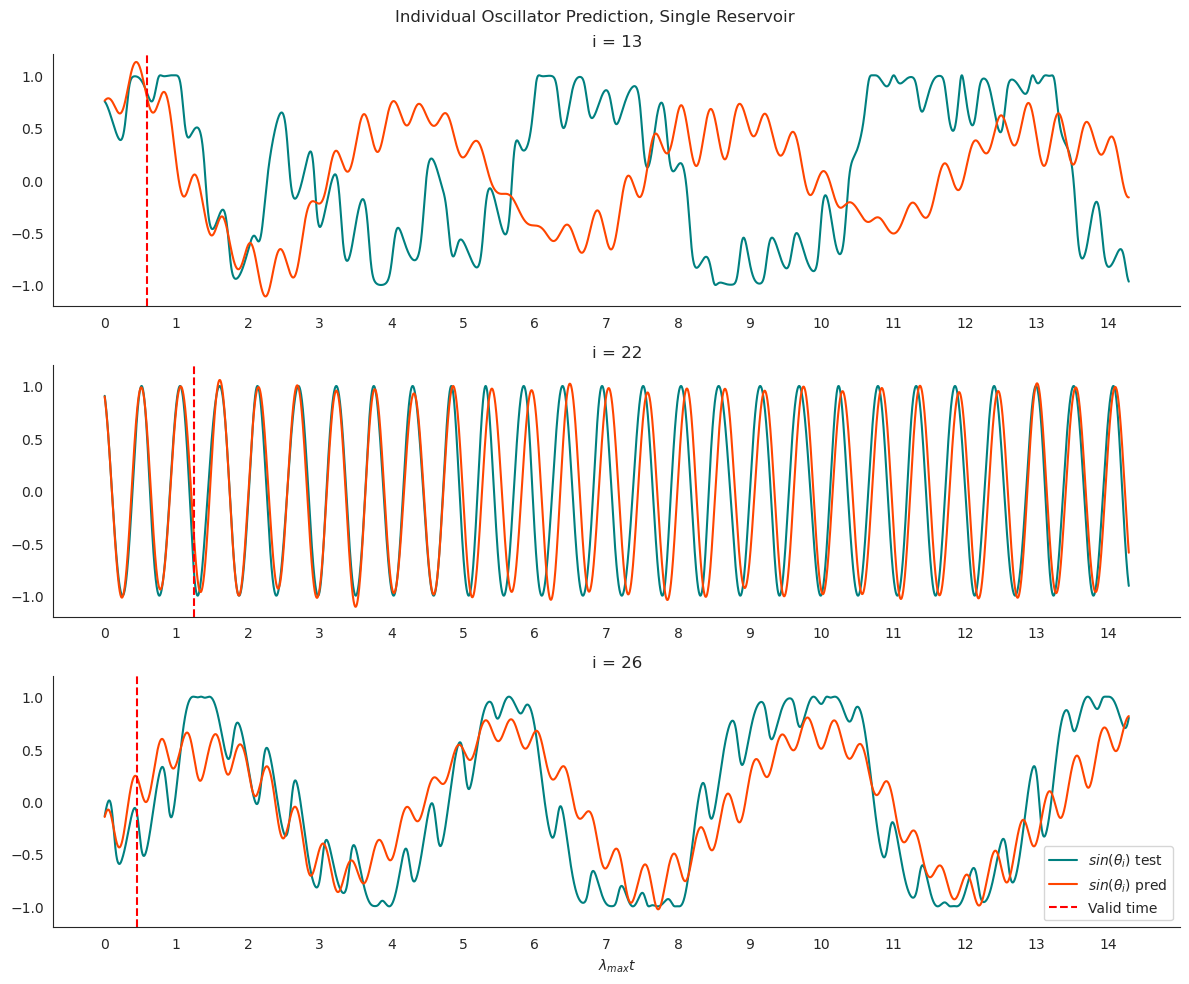

In [84]:
oscs = [13, 22, 26]

test_len = 10000
threshold = 0.4

fig, axs = plt.subplots(3,1, figsize=(12,10))
palette = ["orangered", "teal"]
sns.set_style("white")
for ax, osc in zip(axs, oscs):
    
    normalisation = np.sqrt(np.average(np.power(np.linalg.norm(test_datadict[osc][0:test_len, 0:2], axis=1), 2)))
    e = np.linalg.norm(test_datadict[osc][0:test_len, 0:2] - out[osc][0:test_len, 0:2], axis=1)/normalisation

    valid_time = np.where(e > threshold)[0]
    
    sns.lineplot(test_data[0:test_len, osc], ax=ax, color="teal",label=fr"$sin(\theta_i)$ test", legend=False)
    sns.lineplot(outputs[0:test_len, osc], ax=ax, color="orangered", label=fr"$sin(\theta_i)$ pred", legend=False)
    ax.axvline(x=valid_time[0], color='r', linestyle='--', label=f'Valid time')
    ax.set_ylim((-1.2,1.2))
    
    lyapunov_time = 700

    ticks = np.arange(0, len(test_data[0:test_len, osc]), lyapunov_time)
    ax.set_xticks(ticks=ticks, labels=np.arange(len(ticks)))
    ax.set_title(f"i = {osc}")
    sns.despine()
ax.set_xlabel(r"$\lambda_{max}t$")
ax.legend(loc="lower right")
fig.suptitle("Individual Oscillator Prediction, Single Reservoir")
plt.tight_layout()
plt.savefig("osc_pred_single.pdf", format="pdf")

#### The global order parameter for the predicted time series

In [104]:
phases_test = recover_phases(test_data)
phases_pred = recover_phases(outputs)

D = np.mean(np.sum(test[0]["adjacency_matrix"], axis=1))

rt_test = calculate_R(a=test[0]["adjacency_matrix"], data=phases_test, N=N, d=D)
rt_pred = calculate_R(a=test[0]["adjacency_matrix"], data=phases_pred, N=N, d=D)

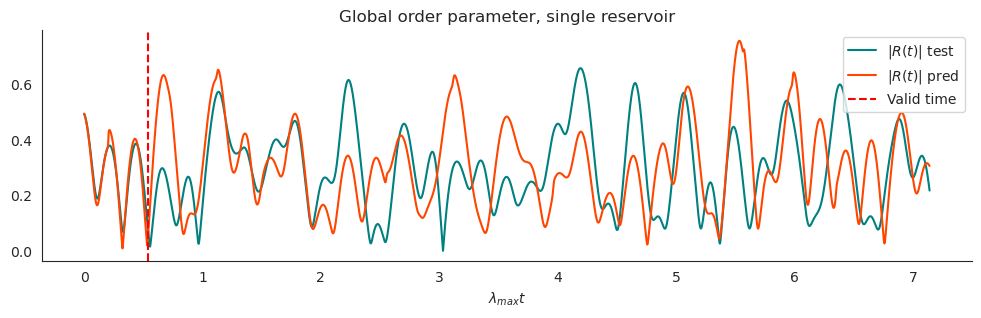

In [105]:
threshold = 0.4
test_len = 5000
normalisation = np.sqrt(np.average(np.power(abs(rt_test[0:test_len]), 2)))
e = np.abs(rt_test[0:test_len] - rt_pred[0:test_len]) / normalisation
valid_time = np.where(e > threshold)[0]
plt.figure(figsize=(12,3))
sns.lineplot(np.abs(rt_test[0:test_len]), color="teal", label=r"$|R(t)|$ test")
sns.lineplot(np.abs(rt_pred[0:test_len]), color="orangered", label=r"$|R(t)|$ pred")
plt.axvline(x=valid_time[0], color='r', linestyle='--', label=f'Valid time')
ticks = np.arange(0, len(rt_test[0:test_len]), lyapunov_time)
plt.xticks(ticks=ticks, labels=np.arange(len(ticks)))
plt.xlabel(r"$\lambda_{max}t$")
plt.legend(loc="upper right")
plt.title("Global order parameter, single reservoir")
sns.despine()
plt.savefig("order_single.pdf", format="pdf", bbox_inches='tight')

In [201]:
normalisation

0.3066948357859032

In [25]:
LY_STEPS = 10000
last_state = internal_trained[-1][-1:, :].T
outputs2, internal_states2 = reservoir.run_auto(init_state=last_state, steps=LY_STEPS)

timestep = 0.02
CALC_LY = 30

rt = internal_states2[1:LY_STEPS + 1, :].T
lyespec = reservoir.lyespectrum(rt, timestep, rout, drout_, CALC_LY)

In [28]:
lyespec

array([ 0.17916011,  0.14893571,  0.09155371,  0.05621743,  0.0330385 ,
        0.01071864, -0.01642882, -0.02639822, -0.09333234, -0.12191329,
       -0.15277255, -0.19207523, -0.2024158 , -0.23828474, -0.29370665,
       -0.338507  , -0.37648392, -0.40498092, -0.4410996 , -0.47130369,
       -0.52260662, -0.55438503, -0.5978404 , -0.60789503, -0.65968081,
       -0.68785356, -0.73790879, -0.75889778, -0.80226358, -0.8259416 ])

In [26]:
def kaplan_yorke(lyevec):
    lysum = 0
    i=0
    while lysum >= 0:
        lysum = lysum + lyevec[i]
        i=i+1    
    return i-1 + (lysum - lyevec[i-1])/np.abs(lyevec[i-1])

In [27]:
kaplan_yorke(lyespec)

11.56633480169579

# Shared memory parallel scheme with same hyperparameters for all reservoirs

In [106]:
test = np.load("../notebooks/simulation_data/coupled_kuramoto/N30/lsoda_test_02.npy", allow_pickle=True)
test_data = np.concatenate((np.sin(test[0]["data"]), np.cos(test[0]["data"])), axis=1)
test_datadict = construct_data(a=test[0]["adjacency_matrix"], data=test_data)
N = test[0]["N"]

In [107]:
pred = np.load(f"../outputs/kuramoto/N{N}/pred_all_lsoda_02.npy", allow_pickle=True)

In [16]:
test = np.load("../notebooks/simulation_data/coupled_kuramoto/N30/euler_test_02.npy", allow_pickle=True)
test_data = np.concatenate((np.sin(test[0]["data"]), np.cos(test[0]["data"])), axis=1)
test_datadict = construct_data(a=test[0]["adjacency_matrix"], data=test_data)

In [17]:
pred = np.load(f"../outputs/kuramoto/N{N}/pred_all_euler_02.npy", allow_pickle=True)

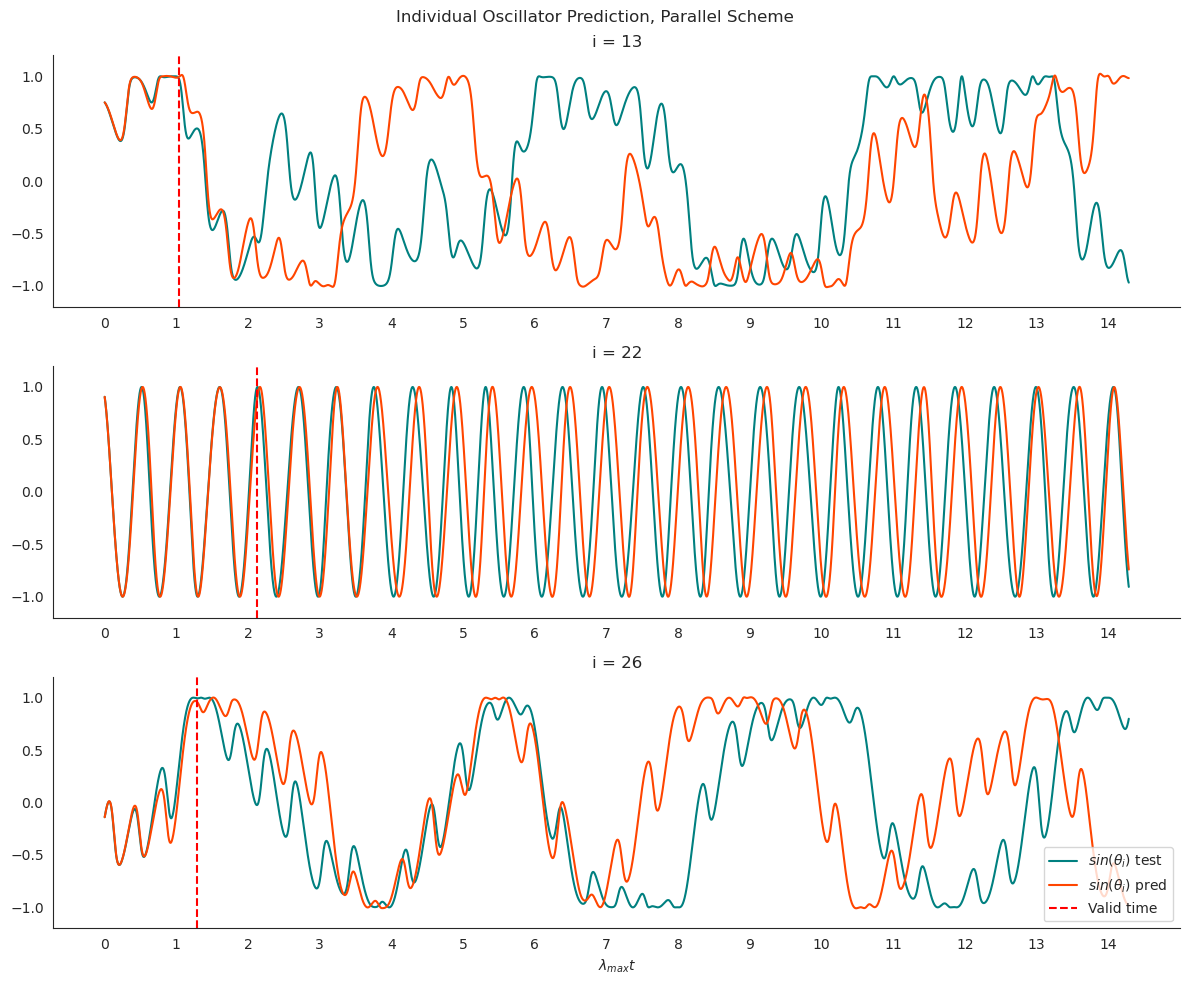

In [80]:
ranks = [13, 22, 26]

test_len = 10000
threshold = 0.4

fig, axs = plt.subplots(3,1, figsize=(12,10))
palette = ["orangered", "teal"]
sns.set_style("white")
for ax, rank in zip(axs, ranks):
    
    normalisation = np.sqrt(np.average(np.power(np.linalg.norm(test_datadict[rank][0:test_len, 0:2], axis=1), 2)))
    e = np.linalg.norm(test_datadict[rank][0:test_len, 0:2] - pred[0:test_len, rank, :], axis=1)/normalisation

    valid_time = np.where(e > threshold)[0]
    
    sns.lineplot(test_datadict[rank][0:test_len,0], ax=ax, color="teal",label=fr"$sin(\theta_i)$ test", legend=False)
    sns.lineplot(pred[0:test_len,rank, 0], ax=ax, color="orangered", label=fr"$sin(\theta_i)$ pred", legend=False)
    ax.axvline(x=valid_time[0], color='r', linestyle='--', label=f'Valid time')
    ax.set_ylim((-1.2,1.2))
    
    lyapunov_time = 700

    ticks = np.arange(0, len(test_datadict[rank][0:test_len,0]), lyapunov_time)
    ax.set_xticks(ticks=ticks, labels=np.arange(len(ticks)))
    ax.set_title(f"i = {rank}")
    plt.tight_layout()
    sns.despine()
ax.set_xlabel(r"$\lambda_{max}t$")
ax.legend(loc="lower right")
fig.suptitle("Individual Oscillator Prediction, Parallel Scheme")
plt.tight_layout()
plt.savefig("osc_pred_parallel.pdf", format="pdf")

724

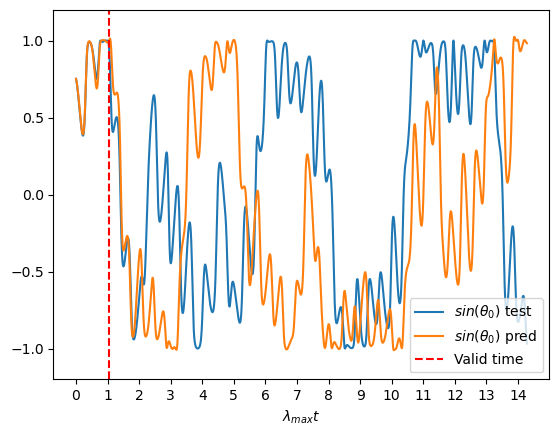

In [24]:
rank = 13
test_len = 10000
threshold = 0.4

normalisation = np.sqrt(np.average(np.power(np.linalg.norm(test_datadict[rank][0:test_len, 0:2], axis=1), 2)))
e = np.linalg.norm(test_datadict[rank][0:test_len, 0:2] - pred[0:test_len, rank, :], axis=1)/normalisation

valid_time = np.where(e > threshold)[0]


plt.plot(test_datadict[rank][0:test_len,0], label=r"$sin(\theta_0)$ test")
plt.plot(pred[0:test_len,rank, 0], label=r"$sin(\theta_0)$ pred")
plt.axvline(x=valid_time[0], color='r', linestyle='--', label=f'Valid time')
plt.ylim((-1.2,1.2))

lyapunov_time = 700

ticks = np.arange(0, len(test_datadict[rank][0:test_len,0]), lyapunov_time)
plt.xticks(ticks=ticks, labels=np.arange(len(ticks)))
plt.xlabel(r"$\lambda_{max}t$")
plt.legend()
valid_time[0]

In [91]:
def recover_phases2(data):
    sine_values = data[:, :, 0]
    cosine_values = data[:, :, 1]
    phase_data = np.arctan2(sine_values, cosine_values)
    return phase_data

In [108]:
phases_test = recover_phases(test_data)
phases_pred = recover_phases2(pred)
D = np.mean(np.sum(test[0]["adjacency_matrix"], axis=1))
rt_test = calculate_R(a=test[0]["adjacency_matrix"], data=phases_test, N=N, d=D)
rt_pred = calculate_R(a=test[0]["adjacency_matrix"], data=phases_pred, N=N, d=D)

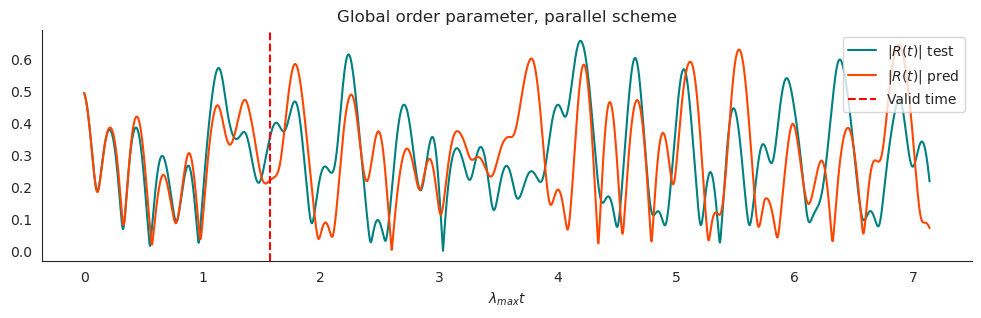

In [109]:
test_len = 5000
threshold = 0.4
normalisation = np.sqrt(np.average(np.power(abs(rt_test[0:test_len]), 2)))
e = (np.abs(np.abs(rt_test[0:test_len]) - np.abs(rt_pred[0:test_len]))) / normalisation
valid_time = np.where(e > threshold)[0]
plt.figure(figsize=(12,3))
sns.lineplot(np.abs(rt_test[0:test_len]), color="teal",label=r"$|R(t)|$ test")
sns.lineplot(np.abs(rt_pred[0:test_len]), color="orangered", label=r"$|R(t)|$ pred")
plt.axvline(x=valid_time[0], color='r', linestyle='--', label=f'Valid time')
ticks = np.arange(0, len(rt_test[0:test_len]), lyapunov_time)
plt.xticks(ticks=ticks, labels=np.arange(len(ticks)))
plt.xlabel(r"$\lambda_{max}t$")
plt.legend(loc="upper right")
plt.title("Global order parameter, parallel scheme")
valid_time[0]
sns.despine()
plt.savefig("order_parallel.pdf", format="pdf", bbox_inches='tight')

In [147]:
plt.savefig("kuramoto50_order_param_euler_parallel.pdf", format="pdf")

<Figure size 640x480 with 0 Axes>

In [5]:
vt = {"euler":[], "lsoda":[]}
dt = 0.01
lyapunov_time = int(20/dt)
test_len = 10000
threshold = 0.4

In [42]:
for m in vt.keys():
    test = np.load(f"../notebooks/simulation_data/coupled_kuramoto/N20/{m}_test_01.npy", allow_pickle=True)
    N = test[0]["N"]
    test_data = np.concatenate((np.sin(test[0]["data"]), np.cos(test[0]["data"])), axis=1)
    test_datadict = construct_data(a=test[0]["adjacency_matrix"], data=test_data)
    pred = np.load(f"../outputs/kuramoto/N{N}/pred_all_{m}_01.npy", allow_pickle=True)
    for n in range(N):
        for i in range(2):
            normalisation = np.sqrt(np.average(np.power(abs(test_datadict[n][0:test_len,i]), 2)))
            e = (np.abs(test_datadict[n][0:test_len,i] - pred[0:test_len,n, i])) / normalisation
            valid_time = np.where(e > threshold)[0]
            if not np.any(valid_time):
                vt[m].append(test_len)
            else:
                vt[m].append(valid_time[0])
        

In [43]:
mean_euler = np.mean(vt["euler"])
median_euler = np.median(vt["euler"])
std_euler = np.std(vt["euler"])
print(f"Euler\nMean: {mean_euler}\nMedian: {median_euler}\nSD: {std_euler}")

Euler
Mean: 2937.0175
Median: 1756.5
SD: 2916.2585940196986


In [44]:
mean_lsoda = np.mean(vt["lsoda"])
median_lsoda = np.median(vt["lsoda"])
std_lsoda = np.std(vt["lsoda"])
print(f"lsoda\nMean: {mean_lsoda}\nMedian: {median_lsoda}\nSD: {std_lsoda}")

lsoda
Mean: 1713.44
Median: 1135.5
SD: 1696.6108205478356


In [45]:
len(vt["lsoda"])

400

In [46]:
for m in vt.keys():
    vt[m] = [t / lyapunov_time for t in vt[m]]
df = pd.DataFrame(vt)
df.to_csv(f"../outputs/kuramoto/N{N}/dt0_01/vt.csv", index=False)

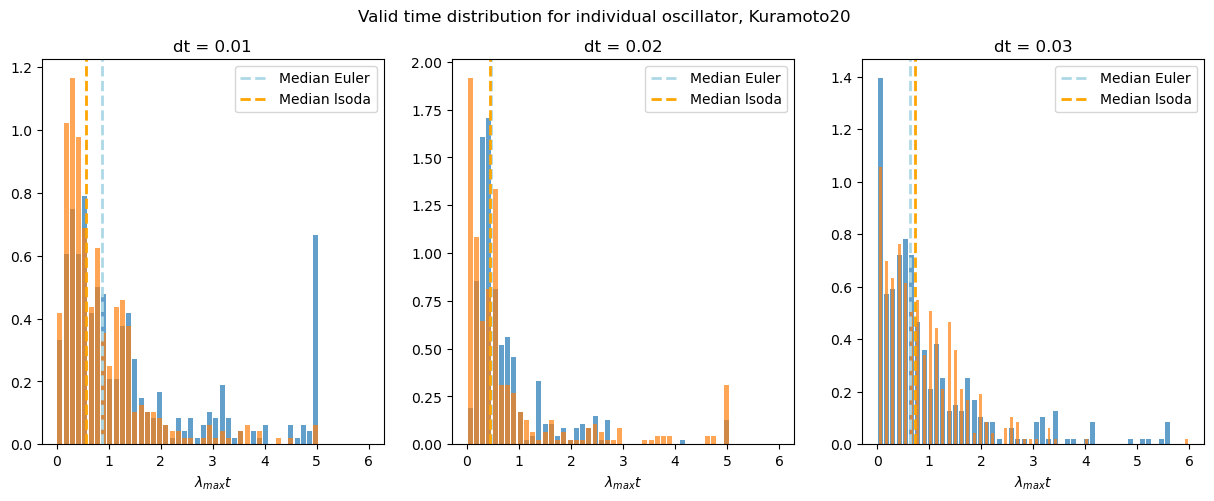

In [47]:
timesteps = ['01', '02', '03']

fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.suptitle("Valid time distribution for individual oscillator, Kuramoto20")

for i, dt in enumerate(timesteps):

    df = pd.read_csv(f"../outputs/kuramoto/N{N}/dt0_{dt}/vt.csv")

    ax[i].hist(df["euler"], bins = 50, rwidth = 0.8, alpha=0.7, density=True, range=[0,6])
    ax[i].hist(df["lsoda"], bins = 50, rwidth = 0.8* (np.max(df["euler"]) - np.min(df["euler"])) / (np.max(df["lsoda"]) - np.min(df["lsoda"])), alpha=0.7, density=True, range=[0,6])
    ax[i].set_xlabel(r"$\lambda_{max}t$")
    ax[i].set_title(f"dt = 0.{dt}")
    ax[i].axvline(np.median(df["euler"]), color='lightblue', linestyle='dashed', linewidth=2, label='Median Euler')
    ax[i].axvline(np.median(df["lsoda"]), color='orange', linestyle='dashed', linewidth=2, label='Median lsoda')
    ax[i].legend()

In [49]:
fig.savefig("kuramoto20_dt_vt.pdf", format="pdf")

## Single Reservoir vs Parallel Scheme

In [91]:
def single_res_vt(vt_sub, vt_order, threshold=0.4, test_len = 10000):
    # subsystem valid times
    test = np.load("../notebooks/simulation_data/coupled_kuramoto/N30/lsoda_test_02.npy", allow_pickle=True)
    test_data = np.concatenate((np.sin(test[0]["data"]), np.cos(test[0]["data"])), axis=1)
    test_datadict = construct_data(a=test[0]["adjacency_matrix"], data=test_data)
    N = test[0]["N"]
    
    outputs = np.load(f"../outputs/kuramoto/N{test[0]['N']}/pred_all_single_res_lsoda_{str(test[0]['dt'])[2:]}.npy")
    out = construct_data(a=test[0]["adjacency_matrix"], data=outputs)
    
    for osc in range(30):
        normalisation = np.sqrt(np.average(np.power(np.linalg.norm(test_datadict[osc][0:test_len, 0:2], axis=1), 2)))
        e = np.linalg.norm(test_datadict[osc][0:test_len, 0:2] - out[osc][0:test_len, 0:2], axis=1)/normalisation
        valid_time = np.where(e > threshold)[0]
        if not np.any(valid_time):
            vt_sub["single"].append(test_len)
        else:
            vt_sub["single"].append(valid_time[0])
            
    phases_test = recover_phases(test_data)
    phases_pred = recover_phases(outputs)

    D = np.mean(np.sum(test[0]["adjacency_matrix"], axis=1))

    rt_test = calculate_R(a=test[0]["adjacency_matrix"], data=phases_test, N=N, d=D)
    rt_pred = calculate_R(a=test[0]["adjacency_matrix"], data=phases_pred, N=N, d=D)
    
    normalisation = np.sqrt(np.average(np.power(abs(rt_test[0:test_len]), 2)))
    e = np.abs(rt_test[0:test_len] - rt_pred[0:test_len]) / normalisation
    valid_time = np.where(e > threshold)[0]
    
    if not np.any(valid_time):
        vt_order["single"].append(test_len)
    else:
        vt_order["single"].append(valid_time[0])

    return vt_sub, vt_order


def parallel_vt(vt_sub, vt_order, threshold=0.4, test_len = 10000):
    # subsystem valid times
    test = np.load("../notebooks/simulation_data/coupled_kuramoto/N30/lsoda_test_02.npy", allow_pickle=True)
    test_data = np.concatenate((np.sin(test[0]["data"]), np.cos(test[0]["data"])), axis=1)
    test_datadict = construct_data(a=test[0]["adjacency_matrix"], data=test_data)
    N = test[0]["N"]
    
    outputs = np.load(f"../outputs/kuramoto/N{test[0]['N']}/pred_all_lsoda_{str(test[0]['dt'])[2:]}.npy")
    
    for osc in range(30):
        normalisation = np.sqrt(np.average(np.power(np.linalg.norm(test_datadict[osc][0:test_len, 0:2], axis=1), 2)))
        e = np.linalg.norm(test_datadict[osc][0:test_len, 0:2] - outputs[0:test_len, osc, :], axis=1)/normalisation
        valid_time = np.where(e > threshold)[0]
        if not np.any(valid_time):
            vt_sub["parallel"].append(test_len)
        else:
            vt_sub["parallel"].append(valid_time[0])
            
    # order parameter valid time
    phases_test = recover_phases(test_data)
    phases_pred = recover_phases2(outputs)
    D = np.mean(np.sum(test[0]["adjacency_matrix"], axis=1))
    rt_test = calculate_R(a=test[0]["adjacency_matrix"], data=phases_test, N=N, d=D)
    rt_pred = calculate_R(a=test[0]["adjacency_matrix"], data=phases_pred, N=N, d=D)
    
    normalisation = np.sqrt(np.average(np.power(abs(rt_test[0:test_len]), 2)))
    e = (np.abs(rt_test[0:test_len] - rt_pred[0:test_len])) / normalisation
    valid_time = np.where(e > threshold)[0]
    
    if not np.any(valid_time):
        vt_order["parallel"].append(test_len)
    else:
        vt_order["parallel"].append(valid_time[0])
        
    return vt_sub, vt_order

In [92]:
vt_sub = {"single":[], "parallel":[]}
vt_order = {"single":[], "parallel":[]}

In [110]:
dt = 0.02
lyapunov_time = int(14/dt)
test_len = 10000
threshold = 0.4

In [112]:
# Load dictionaries from the file
with open('vt.pkl', 'rb') as f:
    vt_sub = pickle.load(f)
    vt_order = pickle.load(f)

In [422]:
vt_sub, vt_order = single_res_vt(vt_sub, vt_order)

In [423]:
vt_sub, vt_order = parallel_vt(vt_sub, vt_order)

In [115]:
for m in vt_sub.keys():
    vt_sub[m] = [t / lyapunov_time for t in vt_sub[m]]

In [116]:
for m in vt_order.keys():
    vt_order[m] = [t / lyapunov_time for t in vt_order[m]]

In [121]:
print("mean subsystem valid time (single):", np.mean(vt_sub["single"]))
print("mean subsystem valid time (parallel):", np.mean(vt_sub["parallel"]))

print("subsystem valid time SD (single):", np.std(vt_sub["single"]))
print("subsystem valid time SD (parallel):", np.std(vt_sub["parallel"]))

print("mean order param valid time (single):", np.mean(vt_order["single"]))
print("mean order param valid time (parallel):", np.mean(vt_order["parallel"]))

print("order param valid time SD (single):", np.std(vt_order["single"]))
print("order param valid time SD (parallel):", np.std(vt_order["parallel"]))

mean subsystem valid time (single): 0.9143428571428571
mean subsystem valid time (parallel): 1.9264857142857141
subsystem valid time SD (single): 0.8964726975290246
subsystem valid time SD (parallel): 1.1933223846645535
mean order param valid time (single): 0.5659714285714286
mean order param valid time (parallel): 1.3106857142857142
order param valid time SD (single): 0.33626176513822914
order param valid time SD (parallel): 0.7138939634290293


In [435]:
palette = ["orangered", "teal"]
sns.set_style("white")

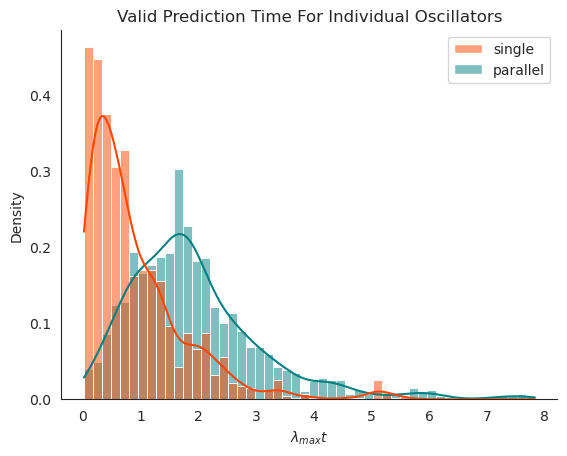

In [442]:
sns.histplot(vt_sub, kde=True, bins=50, palette=sns.color_palette(palette, 2), alpha=0.5, stat="density")
plt.title("Valid Prediction Time For Individual Oscillators")
plt.xlabel(r"$\lambda_{max}t$")
sns.despine()
plt.savefig("single_vs_parallel_sub.pdf", format="pdf")

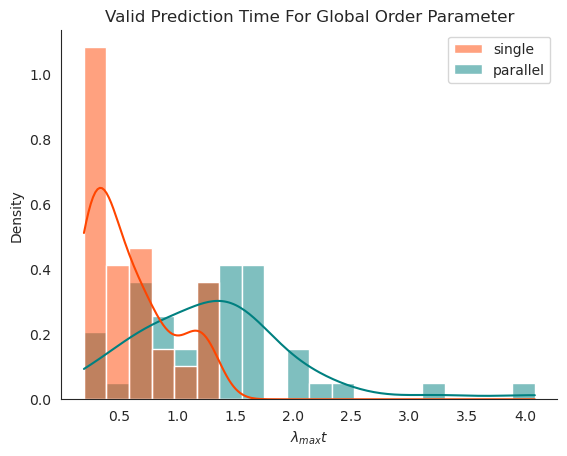

In [441]:
sns.histplot(vt_order, kde=True, bins=20, palette=sns.color_palette(palette, 2), alpha=0.5, stat="density")
plt.title("Valid Prediction Time For Global Order Parameter")
plt.xlabel(r"$\lambda_{max}t$")
sns.despine()
plt.savefig("single_vs_parallel_order.pdf", format="pdf")

In [433]:
# Save dictionaries to a file
with open('vt.pkl', 'wb') as f:
    pickle.dump(vt_sub, f)
    pickle.dump(vt_order, f)

In [429]:
len(vt_order["single"])

50

In [16]:
# Load dictionaries from the file
with open('../outputs/kuramoto/N30/dt0_02/vt_02.pkl', 'rb') as f:
    vt_sub = pickle.load(f)
    vt_order = pickle.load(f)

In [17]:
len(vt_sub["lsoda"])

1200

In [19]:
len(vt_order["lsoda"])

40

Mean 0.01 euler: 1.969408051922168
SD 0.01 euler: 1.1735960657583377
Mean 0.01 lsoda: 1.9361293666430428
SD 0.01 lsoda: 1.1996803606975064
Mean 0.02 euler: 1.7808148035299571
SD 0.02 euler: 1.170845892918616
Mean 0.02 lsoda: 1.801854389923512
SD 0.02 lsoda: 1.1610331069065472
Mean 0.03 euler: 1.7639032477769527
SD 0.03 euler: 1.2075009512672352
Mean 0.03 lsoda: 1.6338715942668052
SD 0.03 lsoda: 1.1476724890501924


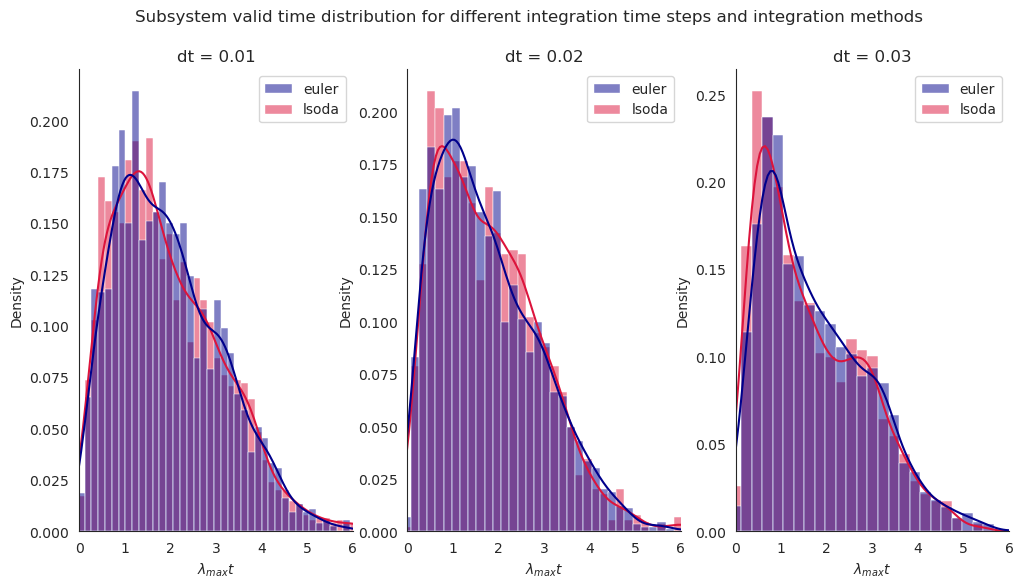

In [39]:
palette = ["darkblue", "crimson"]
sns.set_style("white")
fig, axs = plt.subplots(1,3, figsize=(12,6))
dts = [0.01, 0.02, 0.03]

for dt, ax in zip(dts, axs):
    with open(f'../outputs/kuramoto/N30/dt0_{str(dt)[2:]}/vt_{str(dt)[2:]}.pkl', 'rb') as f:
        vt_sub = pickle.load(f)
        vt_order = pickle.load(f)
    
    lyapunov_time = int(14/dt)
    
    for m in vt_sub.keys():
        vt_sub[m] = [t / lyapunov_time for t in vt_sub[m]]
    
    for m in vt_order.keys():
        vt_order[m] = [t / lyapunov_time for t in vt_order[m]]
            
    for m in vt_sub.keys():
        print(f"Mean {dt} {m}:", np.mean(vt_sub[m]))
        print(f"SD {dt} {m}:", np.std(vt_sub[m]))
    sns.histplot(vt_sub, kde=True, bins=50, palette=sns.color_palette(palette, 2), ax=ax, alpha=0.5, stat="density")
    ax.set_title(f"dt = {dt}")
    ax.set_xlim(0,6)
    ax.set_xlabel(r"$\lambda_{max}t$")
    sns.despine()
plt.suptitle("Subsystem valid time distribution for different integration time steps and integration methods")
plt.savefig("kuramoto_dt_test_sub.pdf",format="pdf")

Mean 0.01 euler: 1.2727620984911714
SD 0.01 euler: 0.9128293906958186
Mean 0.01 lsoda: 1.2394079732428713
SD 0.01 lsoda: 0.8433477359847418
Mean 0.02 euler: 1.3215963815105278
SD 0.02 euler: 0.9550563266695337
Mean 0.02 lsoda: 1.2715801065078658
SD 0.02 lsoda: 0.9397318691274495
Mean 0.03 euler: 1.1387973648607146
SD 0.03 euler: 0.9016972357685163
Mean 0.03 lsoda: 1.1515660850553195
SD 0.03 lsoda: 0.9522138286825254


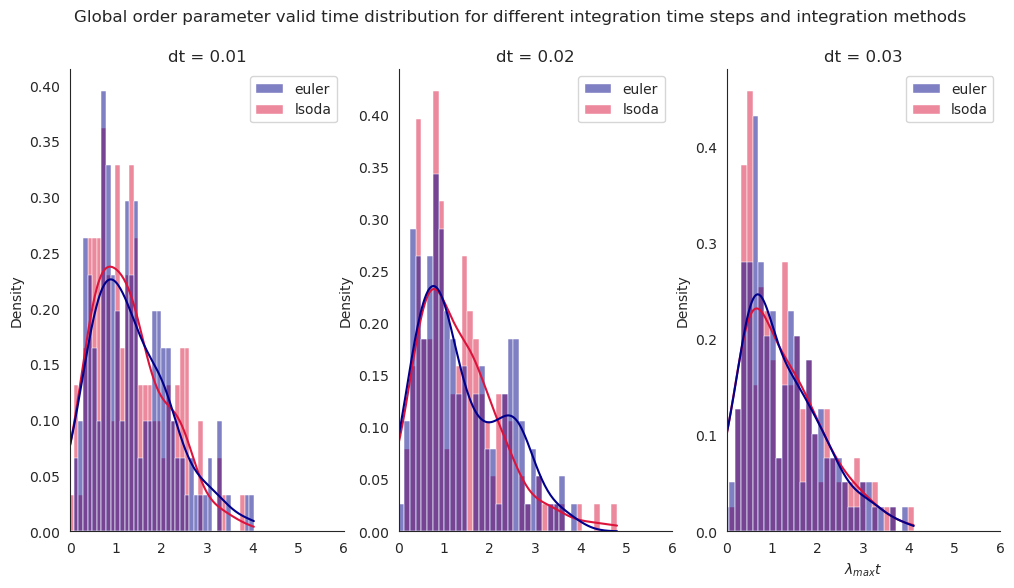

In [27]:
fig, axs = plt.subplots(1,3, figsize=(12,6))
dts = [0.01, 0.02, 0.03]

for dt, ax in zip(dts, axs):
    with open(f'../outputs/kuramoto/N30/dt0_{str(dt)[2:]}/vt_{str(dt)[2:]}.pkl', 'rb') as f:
        vt_sub = pickle.load(f)
        vt_order = pickle.load(f)
        
    lyapunov_time = int(14/dt)
    
    for m in vt_sub.keys():
        vt_sub[m] = [t / lyapunov_time for t in vt_sub[m]]
    
    for m in vt_order.keys():
        vt_order[m] = [t / lyapunov_time for t in vt_order[m]]
    
    for m in vt_order.keys():
        print(f"Mean {dt} {m}:", np.mean(vt_order[m]))
        print(f"SD {dt} {m}:", np.std(vt_order[m]))
    sns.histplot(vt_order, kde=True, bins=50, palette=sns.color_palette(palette, 2), ax=ax, alpha=0.5, stat="density")
    ax.set_title(f"dt = {dt}")
    plt.xlabel(r"$\lambda_{max}t$")
    ax.set_xlim(0,6)
    sns.despine()
    
plt.suptitle("Global order parameter valid time distribution for different integration time steps and integration methods")
plt.savefig("kuramoto_dt_test_order.pdf",format="pdf")